In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import time

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import concatenate
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K
from keras.optimizers import Adam
from keras.constraints import MaxNorm
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [4]:
file = open('a1','rb')
dataset = pickle.load(file, encoding='utf-8')
file.close()

macro_data, micro_data, return_data = dataset
print(macro_data.shape, micro_data.shape, return_data.shape)
print(list(map(type, dataset)))

(3233, 13, 15) (3233, 50, 30) (3233, 50)
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [5]:
# dataset split
train_micro = micro_data[:2000, :, :]
train_macro = macro_data[:2000, :, :]
train_return = return_data[1:2001, :]

validation_micro = micro_data[2001:2600, :, :]
validation_macro = macro_data[2001:2600, :, :]
validation_return = return_data[2002:2601, :]

test_micro = micro_data[2601:-1, :, :]
test_macro = macro_data[2601:-1, :, :]
test_return = return_data[2602:, :]

In [6]:
# model parameter
ndays = train_micro.shape[0]
nstocks = train_micro.shape[1]
nmacro = train_macro.shape[2]
nmicro = train_micro.shape[2]
LSTM_delay = train_macro.shape[1]
n_g = 4
LSTM_units = 4
LSTM_units2 = 4

In [7]:
# SGD networks

# data loading
ma1 = Input(shape=(LSTM_delay, nmacro), name='macro')

mi1 = Input(shape=(nstocks,nmicro), name='micro')

ret1 = Input(shape=(nstocks,), name='return')

g_loaded = Input(shape=(nstocks, n_g), name='function_G')

# LSTM
lstm1_1 = LSTM(LSTM_units, name='lstm')(ma1) # (1000, 4)
lstm1 = Lambda(lambda x:K.repeat(x, nstocks), name='lstm_reshape')(lstm1_1)


# SGD weights DNN
w1 = concatenate([mi1, lstm1], name='micro_macro_combined') # (1000, 50, 104)  
w2 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks*(nmicro+LSTM_units),)), name='ffn_input_reshape')(w1)
w3 = Dense(128, activation='relu', name='ffn_layer1')(w2)
w4 = Dropout(0.2, name='ffn_dropout1')(w3)
w5 = Dense(128, activation='relu', name='ffn_layer2')(w4)
w6 = Dropout(0.2, name='ffn_dropout2')(w5)
# w = Dense(50, name='ffn_output_weights',activation='tanh')(w6)
w = Dense(50, name='ffn_output_weights')(w6)


# SGD construction
def construction(x):
    tmp = 1 - x[0] * x[1]
    tmp = K.sum(tmp, axis=1)
    tmp = K.reshape(tmp, shape=(-1,1)) # (1000, 1)
    tmp = K.repeat(tmp, nstocks) # (1000, 50, 1)
    tmp = K.reshape(tmp, shape=(-1,nstocks)) # (1000, 50)
    tmp = tmp * x[1] # (1000, 50)
    tmp = K.reshape(tmp, shape=(-1, nstocks, 1))
    return tmp # the M_{t+1}R_{t+1}

sgd = Lambda(construction, name='sgd')([w,ret1])


# combine those two and calculate loss
loss_function_w1 = Lambda(lambda x:x[0]*x[1], name='loss')([sgd, g_loaded]) 
loss_function_w = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)), name='loss_reshape')(loss_function_w1)


def mean_squared_error1(y_true, y_pred):
    return K.mean(K.square(K.mean(y_pred-y_true,axis=0)))
#     return K.mean(K.square(y_pred-y_true))

# with weights output for validation and sgd output for condition network training
model_output_w = Model(inputs=[ma1, mi1], outputs=w) # acquires weights given info
model_output_sgd = Model(inputs=[ma1, mi1, ret1], outputs=sgd) # acquires MR for condition networks

model_output_sgd.compile(optimizer='adam', loss=mean_squared_error1)

# SGD model compile
model_w = Model(inputs=[ma1, mi1, ret1, g_loaded], outputs=loss_function_w)
model_w.compile(optimizer='adam', loss=mean_squared_error1)


In [8]:
model_w.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
macro (InputLayer)              (None, 13, 15)       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 4)            320         macro[0][0]                      
__________________________________________________________________________________________________
micro (InputLayer)              (None, 50, 30)       0                                            
__________________________________________________________________________________________________
lstm_reshape (Lambda)           (None, 50, 4)        0           lstm[0][0]                       
____________________________________________________________________________________________

In [9]:
# conditional networks

ma2 = Input(shape=(LSTM_delay, nmacro), name='macro')

mi2 = Input(shape=(nstocks,nmicro), name='micro')

sgd_loaded = Input(shape=(nstocks,1), name='sgd')

lstm2_1 = LSTM(LSTM_units2, name='lstm')(ma2) # (1000, 4)
lstm2 = Lambda(lambda x:K.repeat(x, nstocks), name='lstm_reshape')(lstm2_1)

g0 = concatenate([mi2, lstm2], name='g0') # (1000, 50, 104) 
g1 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks*(nmicro+LSTM_units),)), name='g1')(g0)
# cons = MaxNorm(max_value=0.001, axis=0)
# g2 = Dense(128, activation='relu',kernel_constraint=cons, bias_constraint=cons, name='g2')(g1)
g3 = Dropout(0.2, name='g3')(g1) # (1000, 50, 8)
g4 = Dense(nstocks*n_g, name='g4')(g3) # (1000, 50, 8)
g5 = Lambda(lambda x:K.reshape(x, shape=(-1,nstocks,n_g)), name='g5')(g4)
g = Lambda(lambda x:(x-K.reshape(K.mean(x, axis=-1), (-1,nstocks,1)))/K.reshape(K.std(x, axis=-1), (-1,nstocks,1)), name='g')(g5)

loss_function_g1 = Lambda(lambda x:x[0]*x[1], name='loss')([sgd_loaded, g]) # (1000,50, 8)
loss_function_g = Lambda(lambda x:K.reshape(x, shape=(-1, nstocks*n_g)), name='loss_reshape')(loss_function_g1)

model_output_g = Model(inputs=[ma2, mi2], outputs=g) # acquires MR for condition networks

def mean_squared_error2(y_true, y_pred):
    return -K.mean(K.square(K.mean(y_pred-y_true,axis=0)))
#     return -K.mean(K.square(y_pred-y_true))

model_g = Model(inputs=[ma2, mi2, sgd_loaded], outputs=loss_function_g)
model_g.compile(optimizer='adam', loss=mean_squared_error2)
# model_g.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model_g.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
macro (InputLayer)              (None, 13, 15)       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 4)            320         macro[0][0]                      
__________________________________________________________________________________________________
micro (InputLayer)              (None, 50, 30)       0                                            
__________________________________________________________________________________________________
lstm_reshape (Lambda)           (None, 50, 4)        0           lstm[0][0]                       
____________________________________________________________________________________________

In [11]:
def moving_average(x, n):
    xx = np.cumsum(x)
    xxx = xx.copy()
    xxx[n:] = (xx[n:] - xx[:-n]) / n
    for i in range(n):
        xxx[i] = xxx[i] / (i+1)
    return xxx

In [12]:
# data process
y_validation = np.zeros((validation_macro.shape[0], n_g*nstocks))
y_train = np.zeros((ndays, n_g*nstocks))
y_train_unconditional = np.zeros((ndays, nstocks, 1))

print(y_train.shape)
ma = train_macro
mi = train_micro
ret = train_return
sdf_loss = []

epoch = 200
batch_size = 200
n_iteration = 500

# first use unconditional methods to give a initial guess of sgd
t1 = time.time()
# SDF nets
history_w = model_output_sgd.fit([ma, mi, ret], y_train_unconditional, epochs=epoch, batch_size=batch_size, verbose=0)
function_sgd = model_output_sgd.predict([ma, mi, ret])
sdf_loss = sdf_loss + history_w.history['loss'].copy() # save loss
print('done with', 0,',train loss is', round(sdf_loss[-1],6) ,', using', round(time.time()-t1, 2), 'seconds')
# plt.plot(moving_average(history_w.history['loss'], 20))
# plt.show()

for i in range(30):
    t1 = time.time()
    # conditional nets
    history_w = model_g.fit([ma, mi, function_sgd], y_train, epochs=epoch,  batch_size=batch_size, verbose=0)
    function_g = model_output_g.predict([ma, mi])
    print('done with conditional', i, 'loss is',round(history_w.history['loss'][-1],6),'using', round(time.time()-t1, 2), 'seconds')
#     plt.plot(moving_average(history_w.history['loss'], 20))
#     plt.show()
    
    t1 = time.time()
    # SDF nets
    history_w = model_w.fit([ma, mi, ret, function_g], y_train, epochs=epoch, batch_size=batch_size,  verbose=0)
    function_sgd = model_output_sgd.predict([ma, mi, ret])
    sdf_loss = sdf_loss + history_w.history['loss'].copy() # save loss
    validation_loss = np.mean((model_w.predict([validation_macro, validation_micro, validation_return, function_g]) - y_validation)**2)
    print('done with sgd', i,',train loss is', round(sdf_loss[-1],6), ',validation loss is',round(validation_loss,6), ', using', round(time.time()-t1, 2), 'seconds')
#     plt.plot(moving_average(history_w.history['loss'], 20))
#     plt.show()

(2000, 200)

done with 0 ,train loss is 320659573964.8 , using 23.91 seconds
done with conditional 0 loss is -225378165555.2 using 38.89 seconds
done with sgd 0 ,train loss is 58530173.2 ,validation loss is 29442140162101.7 , using 29.74 seconds
done with conditional 1 loss is -35126611.05 using 39.48 seconds
done with sgd 1 ,train loss is 2909595.64375 ,validation loss is 26995815334555.41 , using 24.55 seconds
done with conditional 2 loss is -670012.064062 using 37.97 seconds
done with sgd 2 ,train loss is 0.170583 ,validation loss is 26935996733807.203 , using 29.94 seconds
done with conditional 3 loss is -0.069975 using 42.14 seconds
done with sgd 3 ,train loss is 0.0136 ,validation loss is 26935936260442.113 , using 27.62 seconds
done with conditional 4 loss is -0.012903 using 39.53 seconds
done with sgd 4 ,train loss is 0.012423 ,validation loss is 26935935212514.508 , using 27.99 seconds
done with conditional 5 loss is -0.011465 using 42.61 seconds
done with sgd 5 ,train loss is

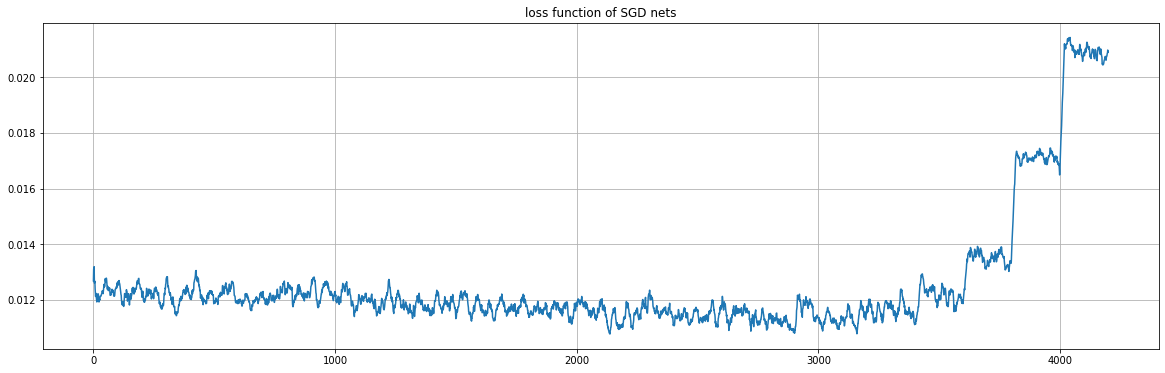

In [17]:
plt.figure(figsize=(20,6))
plt.plot(moving_average(sdf_loss[2000:], 20))
plt.title('loss function of SGD nets')
plt.grid()
plt.show()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


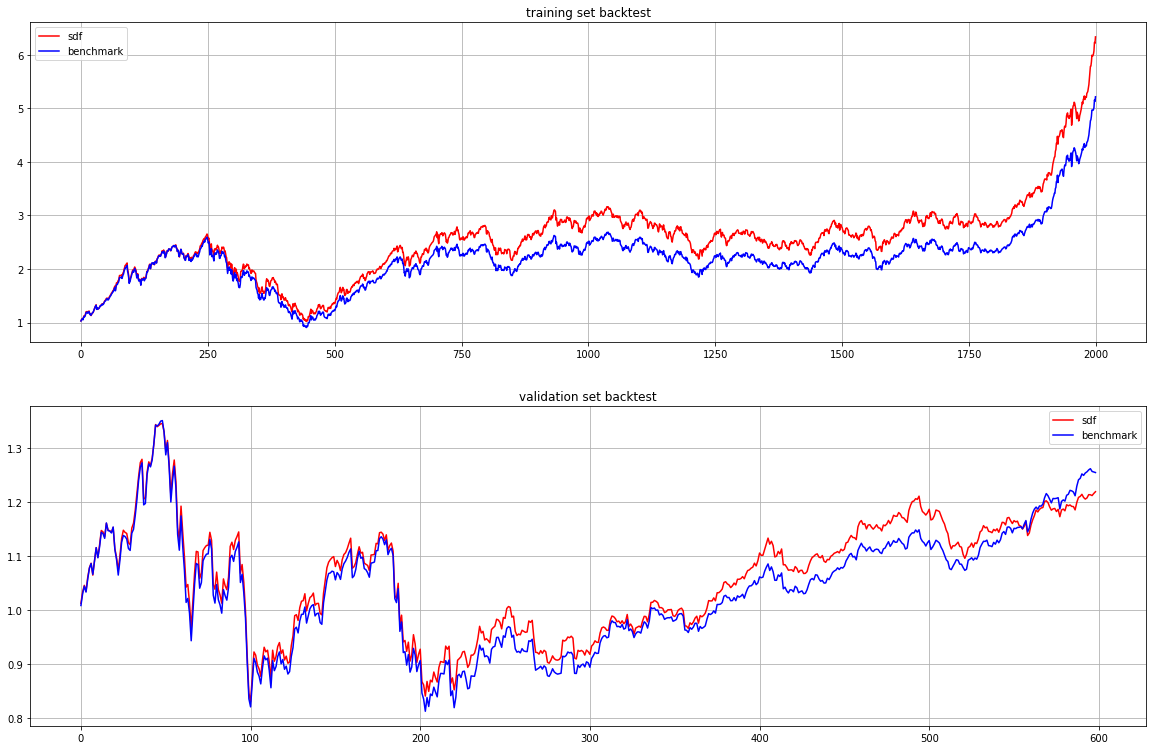

,mean,std,shape,SR,bench_mean,bench_std,bench_SR
train,0.268266,0.266243,2000,1.007599,0.245355,0.272073,0.901796
validation,0.123220,0.280515,599,0.439262,0.136844,0.285843,0.478737
test,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000


In [14]:
result = pd.DataFrame([[0,0,0,0, 0, 0, 0] for i in range(3)], columns = ['mean','std','shape','SR','bench_mean','bench_std','bench_SR'], index=['train','validation','test'])

# training set condition
train_weights = model_output_w.predict([train_macro[:,:], train_micro[:, :, :]])
# train_weights = (train_weights - train_weights.mean(axis=1).reshape(-1,1)) / train_weights.std(axis=1).reshape(-1,1)
train_weights = 1/(1+np.exp(-train_weights)) 
# train_yield = train_weights
train_daily_return = (train_weights/train_weights.sum(axis=1).reshape(-1,1) * train_return).sum(axis=1)
result.iloc[0, 0] = train_daily_return.mean()*252
result.iloc[0, 1] = train_daily_return.std() * np.sqrt(252)
result.iloc[0, 2] = train_daily_return.shape

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(311)
benchmark = train_return.mean(axis=1)
ax1.plot(np.cumprod(1+train_daily_return), color='red',label='sdf')
ax1.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.title('training set backtest')
plt.grid()

result.iloc[0, 3] = train_daily_return.mean()/train_daily_return.std()*np.sqrt(252)
result.iloc[0, 4] = benchmark.mean()*252
result.iloc[0, 5] = benchmark.std()*np.sqrt(252)
result.iloc[0, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)


# training set condition
validation_weights = model_output_w.predict([validation_macro[:,:], validation_micro[:, :, :]])
# validation_weights = (validation_weights - validation_weights.mean(axis=1).reshape(-1,1)) / validation_weights.std(axis=1).reshape(-1,1)
validation_weights = 1/(1+np.exp(-validation_weights))
# train_yield = train_weights
validation_daily_return = (validation_weights/validation_weights.sum(axis=1).reshape(-1,1) * validation_return).sum(axis=1)
result.iloc[1, 0] = validation_daily_return.mean()*252
result.iloc[1, 1] = validation_daily_return.std() * np.sqrt(252)
result.iloc[1, 2] = validation_daily_return.shape

benchmark = validation_return.mean(axis=1)
ax2 = fig.add_subplot(312)
ax2.plot(np.cumprod(1+validation_daily_return), color='red',label='sdf')
ax2.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
plt.legend()
plt.grid()
plt.title('validation set backtest')

result.iloc[1, 3] = validation_daily_return.mean()/validation_daily_return.std()*np.sqrt(252)
result.iloc[1, 4] = benchmark.mean()*252
result.iloc[1, 5] = benchmark.std()*np.sqrt(252)
result.iloc[1, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)

# # training set condition
# test_weights = model_output_w.predict([test_macro[:,:], test_micro[:, :, :]])
# # test_weights = (test_weights - test_weights.mean(axis=1).reshape(-1,1)) / test_weights.std(axis=1).reshape(-1,1)
# test_weights = 1/(1+np.exp(-test_weights))
# # train_yield = train_weights
# test_daily_return = (test_weights/test_weights.sum(axis=1).reshape(-1,1) * test_return).sum(axis=1)
# result.iloc[2, 0] = test_daily_return.mean()*252
# result.iloc[2, 1] = test_daily_return.std() * np.sqrt(252)
# result.iloc[2, 2] = test_daily_return.shape

# benchmark = test_return.mean(axis=1)
# ax2 = fig.add_subplot(313)
# plt.plot(np.cumprod(1+test_daily_return), color='red',label='sdf')
# plt.plot(np.cumprod(1+benchmark), color='blue',label='benchmark')
# plt.legend()
# plt.grid()
# plt.title('test set backtest')

# result.iloc[2, 3] = test_daily_return.mean()/test_daily_return.std()*np.sqrt(252)
# result.iloc[2, 4] = benchmark.mean()*252
# result.iloc[2, 5] = benchmark.std()*np.sqrt(252)
# result.iloc[2, 6] = benchmark.mean()/benchmark.std()*np.sqrt(252)

plt.show()
result

In [15]:
# portfolio weights example after balancing
(train_weights/train_weights.sum(axis=1).reshape(-1,1)).mean(axis=0)

array([9.6557513e-03, 2.8770708e-02, 2.9990179e-02, 3.9672856e-03,
       1.8072449e-02, 3.0032337e-02, 2.2449499e-02, 2.6934462e-02,
       2.0942804e-03, 1.7397243e-03, 2.5538499e-02, 2.8681844e-02,
       2.0362873e-02, 2.9800361e-02, 7.6687406e-03, 3.0041743e-02,
       2.9887373e-02, 1.7455637e-02, 1.0295726e-02, 2.1419520e-02,
       2.5569674e-02, 1.7143359e-02, 1.5487209e-02, 2.7510751e-02,
       2.9865505e-02, 1.7960876e-02, 6.6842362e-03, 2.5252089e-02,
       2.8476970e-02, 3.0040534e-02, 2.8892523e-02, 1.6494380e-02,
       2.0530678e-02, 2.9492205e-02, 1.9527417e-02, 1.3005653e-02,
       8.5782334e-03, 7.3279687e-03, 2.9101421e-04, 2.6469899e-02,
       8.6710112e-05, 2.8422290e-02, 3.0043554e-02, 2.9930366e-02,
       3.0040735e-02, 1.6028835e-03, 3.0043554e-02, 8.8038773e-04,
       2.9457290e-02, 3.0036943e-02], dtype=float32)

In [16]:
## portfolio weights example before balancing
model_output_w.predict([train_macro[:,:], train_micro[:, :, :]])

array([[-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ],
       [-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ],
       [-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ],
       ...,
       [-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ],
       [-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ],
       [-0.7473441,  3.1190484,  6.329764 , ..., -3.5002635,  3.9185975,
         8.552748 ]], dtype=float32)